In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
from gradslam.structures.pointclouds import Pointclouds
from PIL import Image

from core.dataset import ScanNet
from core.integrate import FeatureFusionScalableTSDFVolume
from core.labeler import CLIPTextQuerier, KMeansLabeler
from core.extractor import ConceptFusionFeatureExtractor

In [3]:
device = "cuda:1"
sam_ckpt = "/home/quanta/Models/SAM/sam_vit_h_4b8939.pth"
sam_type = "vit_h"
clip_type = "ViT-B/32"  # this is the clip model used by clip-glass and DeCap
clip_download_root = "/home/quanta/.cache/clip"
lseg_ckpt = "/home/quanta/Models/LSeg/lseg_minimal_e200.ckpt"
grounding_dino_config_pth = "../examples/grounding_dino_config/GroundingDINO_SwinT_OGC.py"
grounding_dino_ckpt = "/home/quanta/Models/GroundingDINO/groundingdino_swint_ogc.pth"
ram_ckpt = "/home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth"
sam_hq_ckpt = "/home/quanta/Models/SAM_HQ/sam_hq_vit_h.pth"
mask_rcnn_ckpt = "/home/quanta/Models/scannet_mask_rcnn/model_0454999.pth"

In [4]:
save_dir  = '../02_conceptfusion/03_2d_analysis/'
os.makedirs(save_dir, exist_ok=True)

In [7]:
img = Image.open('../../examples/fast_food.jpg')

# 0 Hollow part of conceptfusion

In [5]:
extractor = ConceptFusionFeatureExtractor(
    sam_type=sam_type,
    sam_ckpt=sam_ckpt,
    clip_type=clip_type,
    clip_download_root=clip_download_root,
    global_weight=1.0,
    temperature=1.0,
    device=device,
)
torch.cuda.empty_cache()
extractor.load_model()

In [8]:
results = extractor.extract(img)

In [10]:
feats = extractor.get_feats(results=results, device=device, normalize=False)

In [11]:
n = feats.norm(dim=-1)

In [14]:
img = Image.fromarray((n > 1e-5).cpu().numpy())

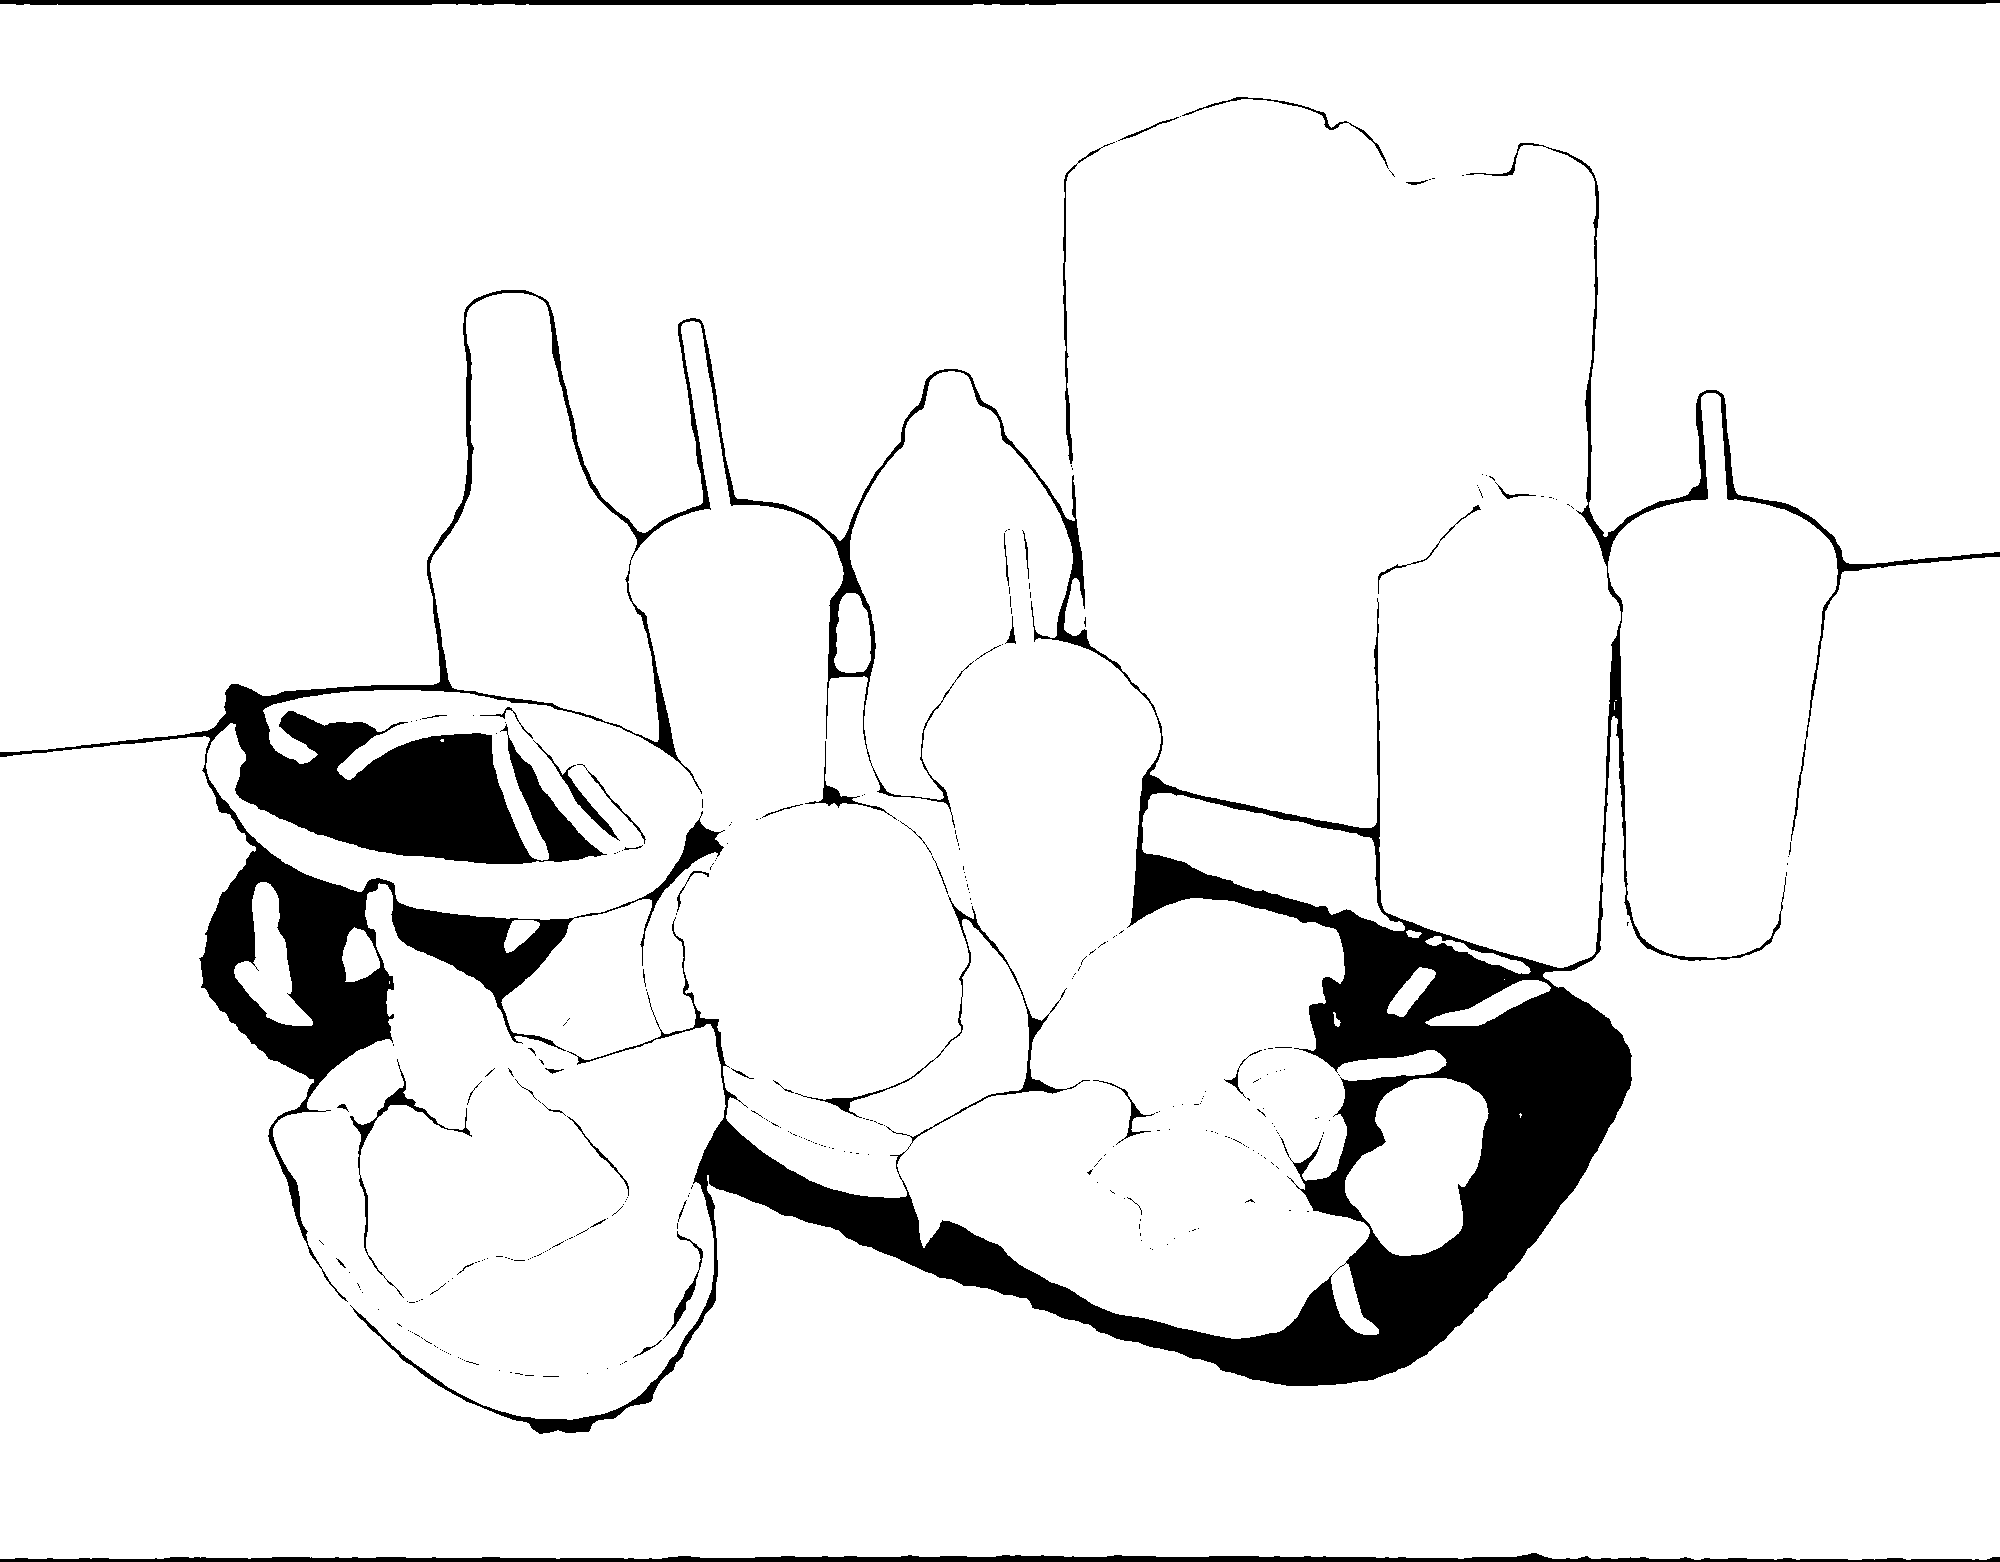

In [15]:
display(img)

In [16]:
img.save(save_dir + 'hollow_part.png')

# 1 Original Conceptfusion

In [6]:
clip_querier = CLIPTextQuerier(device='cuda:1')
clip_querier.load_model()

In [11]:
sent1 = "there is a paper bag left to a cup of cocacola and it is right to a yellow bottle of sause."
with open(save_dir + 'sent_1.txt', 'w') as f:
    f.write(sent1)

In [15]:
score = clip_querier.single_text_score(
    text=sent1,
    img_feats=feats,
)
score = score.clip(0.15, 1.0)

In [16]:
color = clip_querier.score_to_color(
    score=score,
    normalize=True,
    # threshold=0.6
)

In [17]:
img = Image.fromarray((np.asarray(color) * 255).astype(np.uint8))

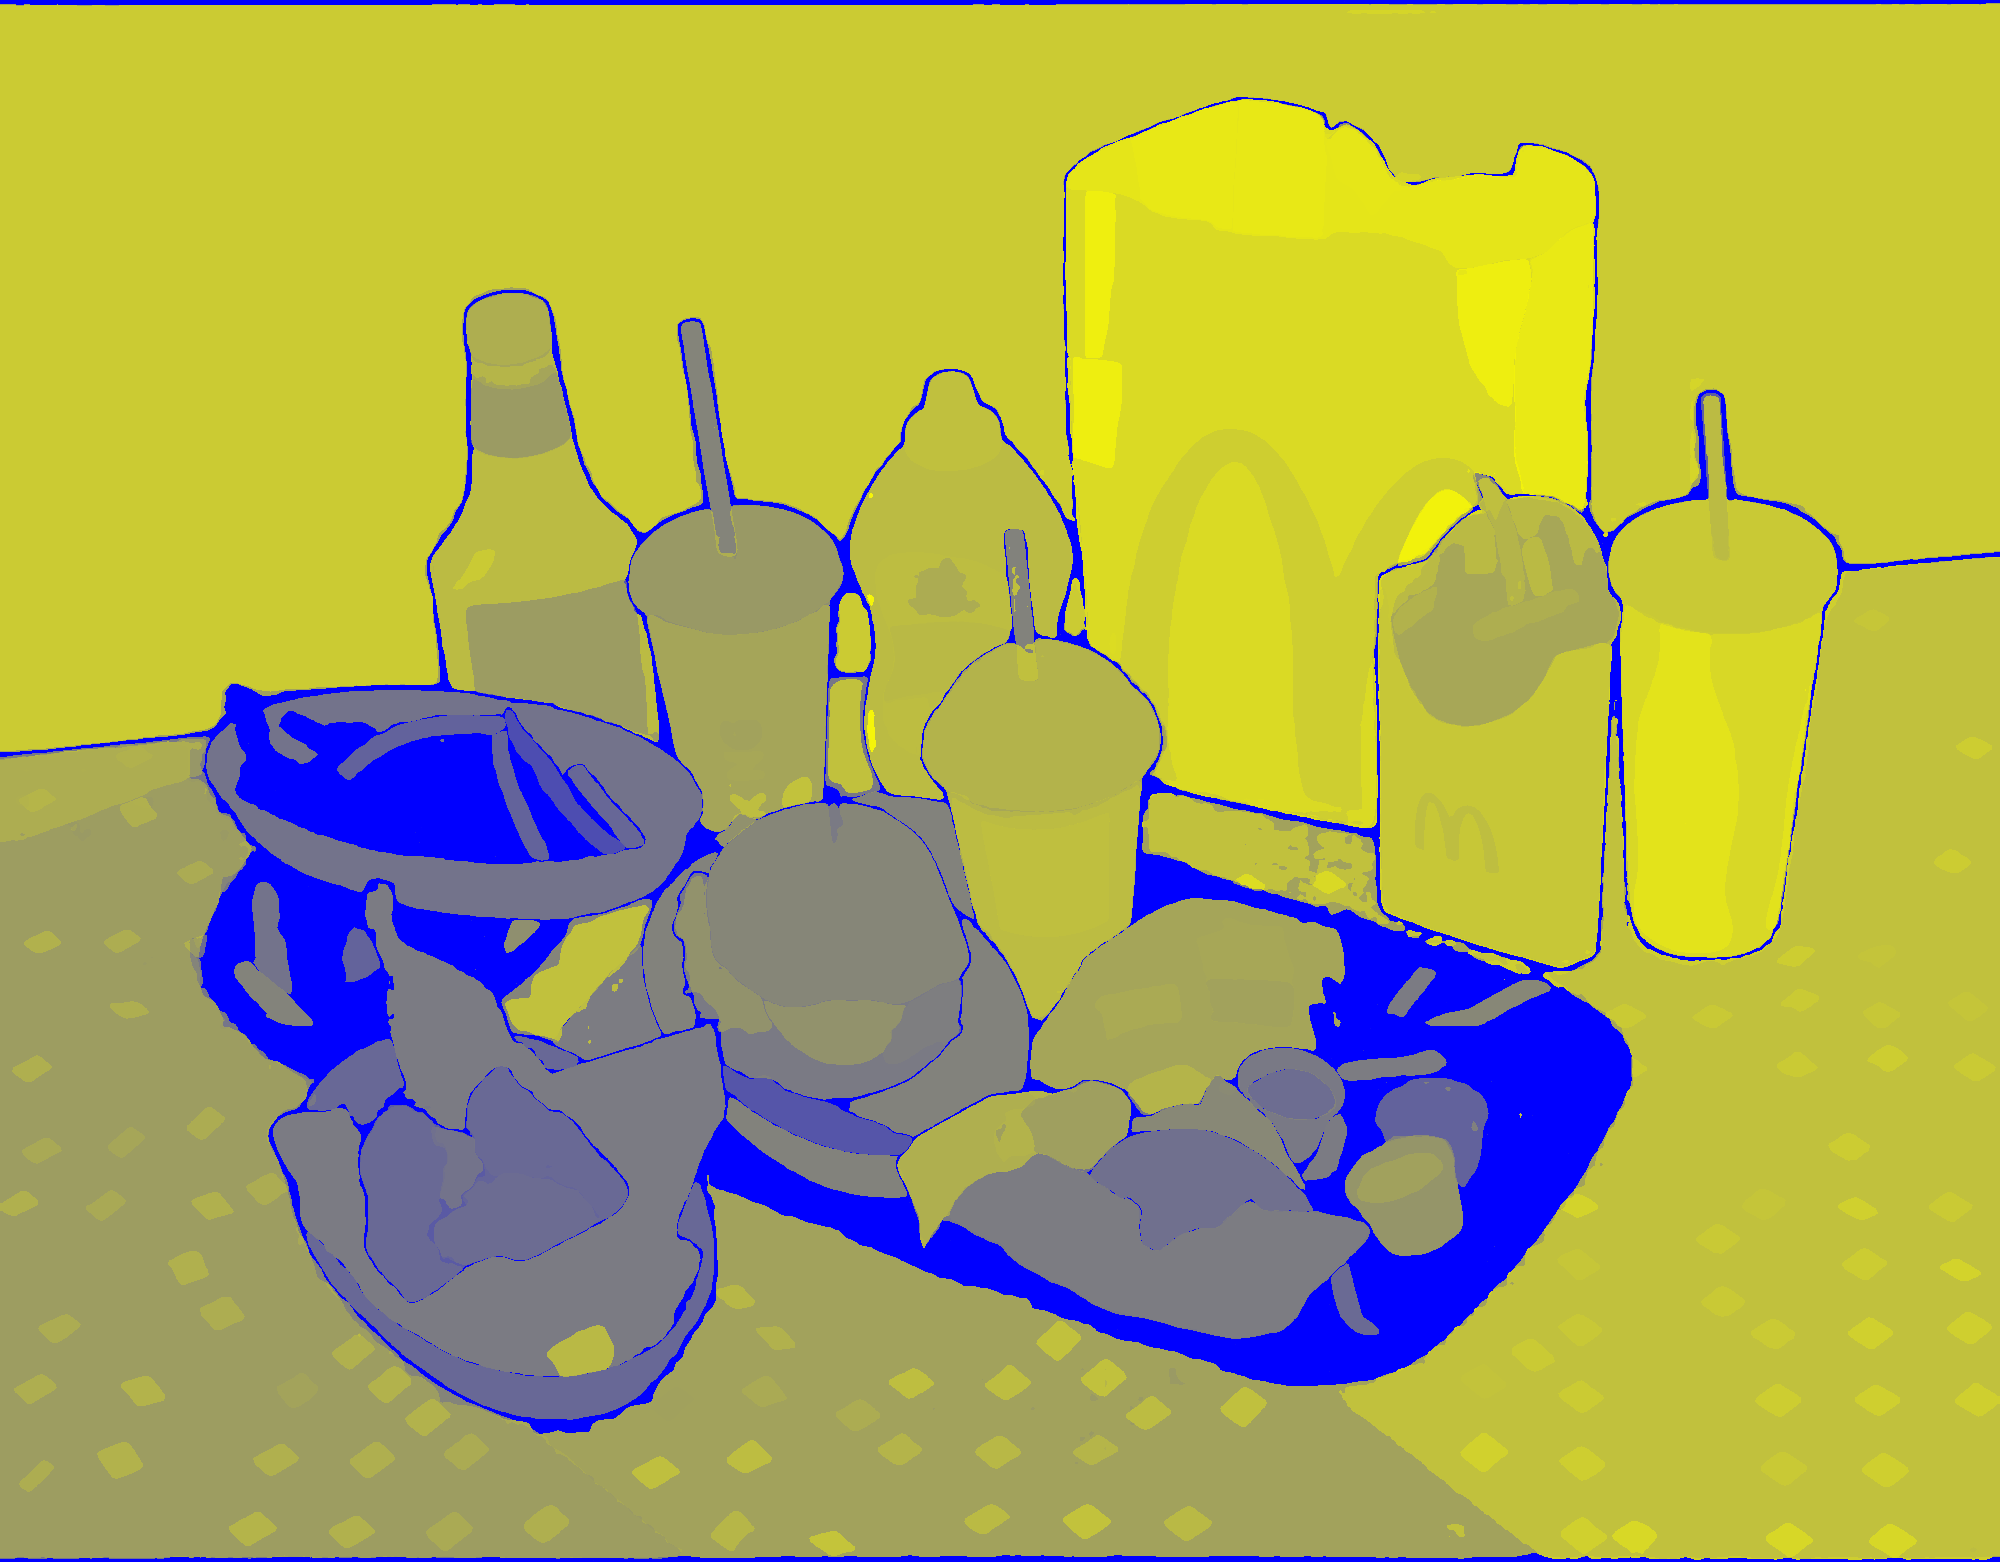

In [18]:
display(img)

In [19]:
img.save(save_dir + 'sent1_original.png')

In [12]:
sent2 = "tablecloth"
with open(save_dir + 'sent_2.txt', 'w') as f:
    f.write(sent2)

In [21]:
score = clip_querier.single_text_score(
    text=sent2,
    img_feats=feats,
)
score = score.clip(0.15, 1.0)

In [22]:
color = clip_querier.score_to_color(
    score=score,
    normalize=True,
    # threshold=0.6
)

In [24]:
img = Image.fromarray((np.asarray(color) * 255).astype(np.uint8))

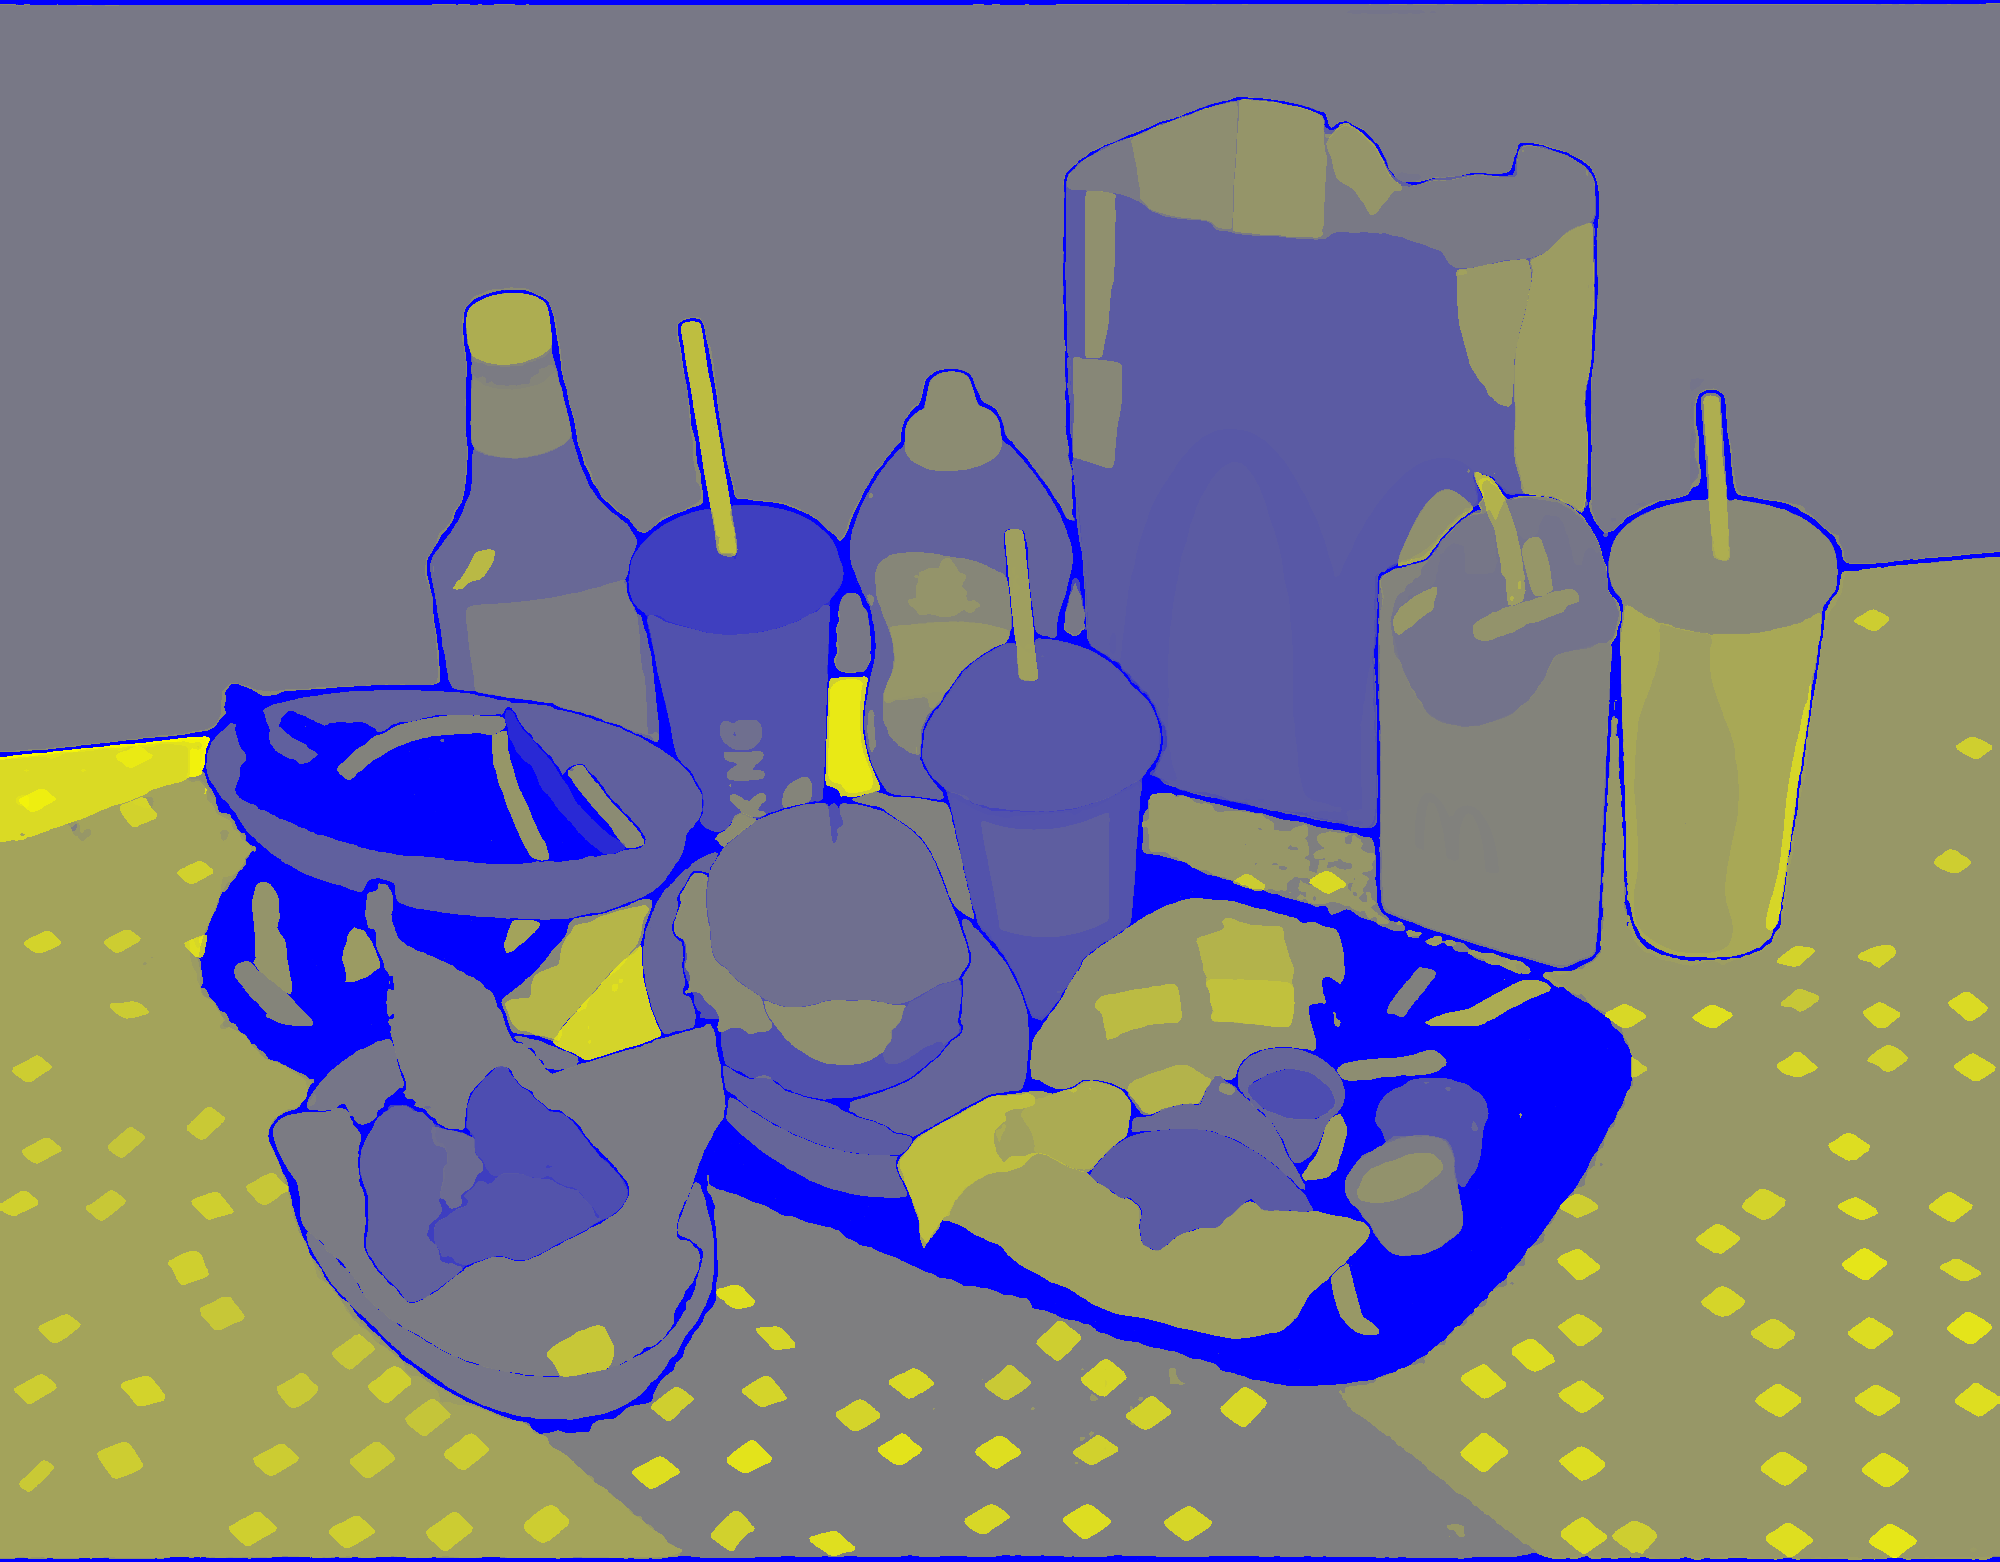

In [25]:
display(img)

In [26]:
img.save(save_dir + 'sent2_original.png')

# 2 enhanced version

In [7]:
extractor = ConceptFusionFeatureExtractor(
    sam_type=sam_type,
    sam_ckpt=sam_ckpt,
    clip_type=clip_type,
    clip_download_root=clip_download_root,
    weaken_background=True,
    weaken_factor=0.01,
    extend_ratio=1.0,
    global_weight=1.0,
    temperature=1.0,
    device=device,
)
torch.cuda.empty_cache()
extractor.load_model()

In [8]:
results = extractor.extract(img)

In [9]:
feats = extractor.get_feats(results=results, device=device)

In [13]:
score = clip_querier.single_text_score(
    text=sent1,
    img_feats=feats,
)
score = score.clip(0.15, 1.0)

In [14]:
color = clip_querier.score_to_color(
    score=score,
    normalize=True,
    # threshold=0.6
)

In [15]:
img = Image.fromarray((np.asarray(color) * 255).astype(np.uint8))

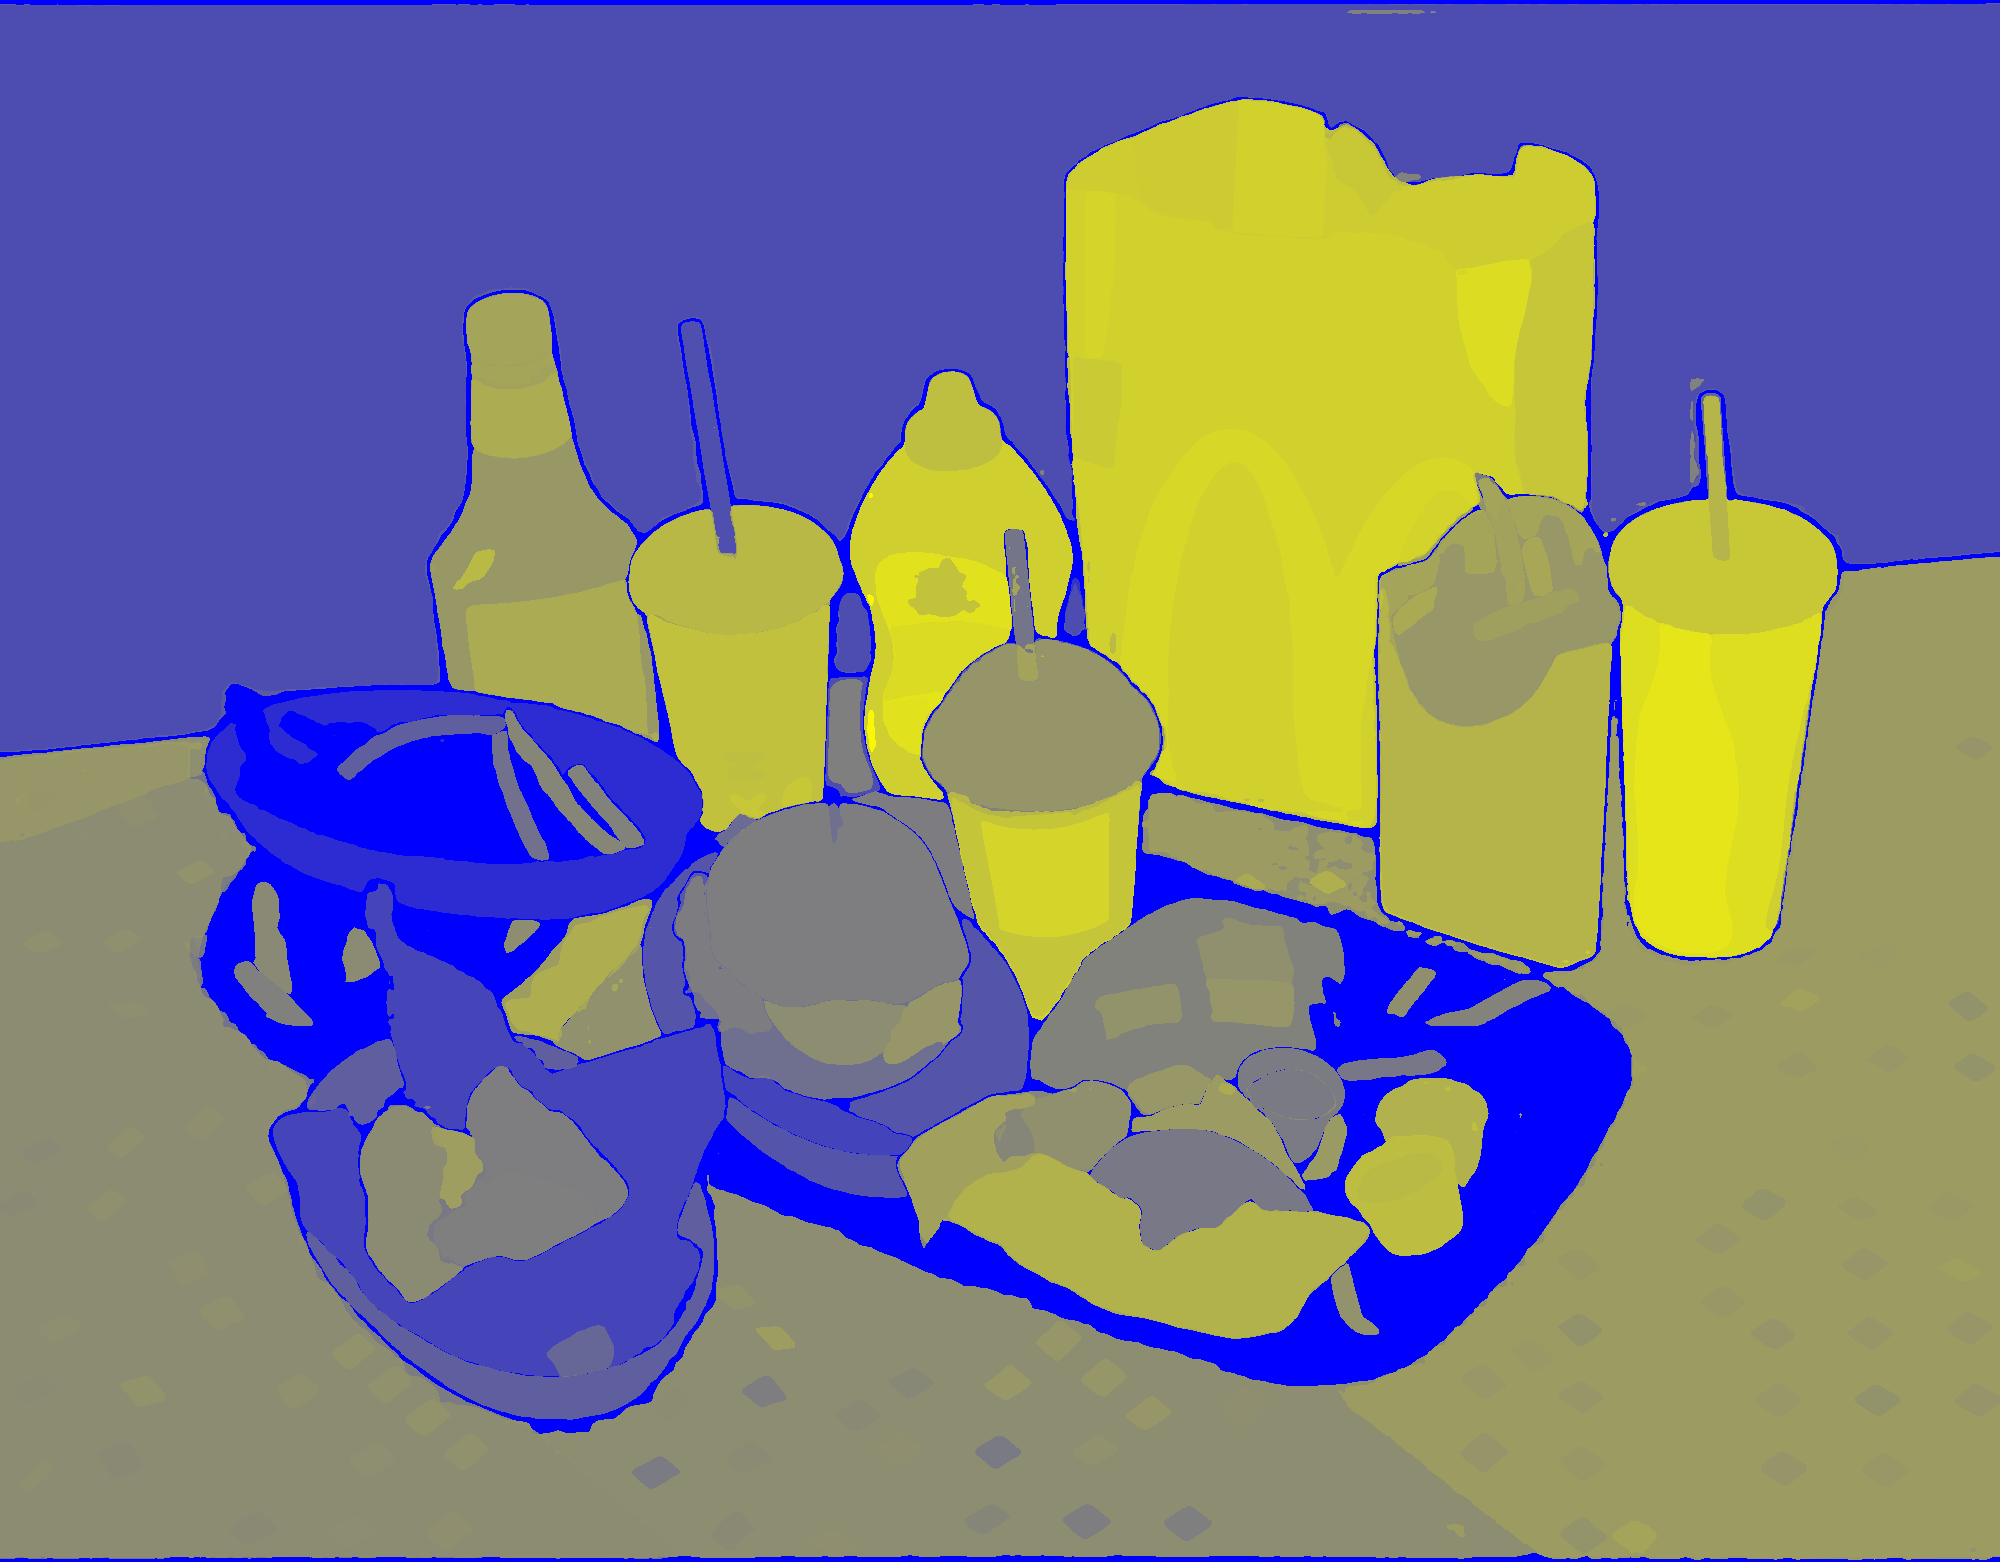

In [16]:
display(img)

In [17]:
img.save(save_dir + 'sent1_enhanced.png')

In [18]:
score = clip_querier.single_text_score(
    text=sent2,
    img_feats=feats,
)
score = score.clip(0.15, 1.0)

In [19]:
color = clip_querier.score_to_color(
    score=score,
    normalize=True,
    # threshold=0.6
)

In [20]:
img = Image.fromarray((np.asarray(color) * 255).astype(np.uint8))

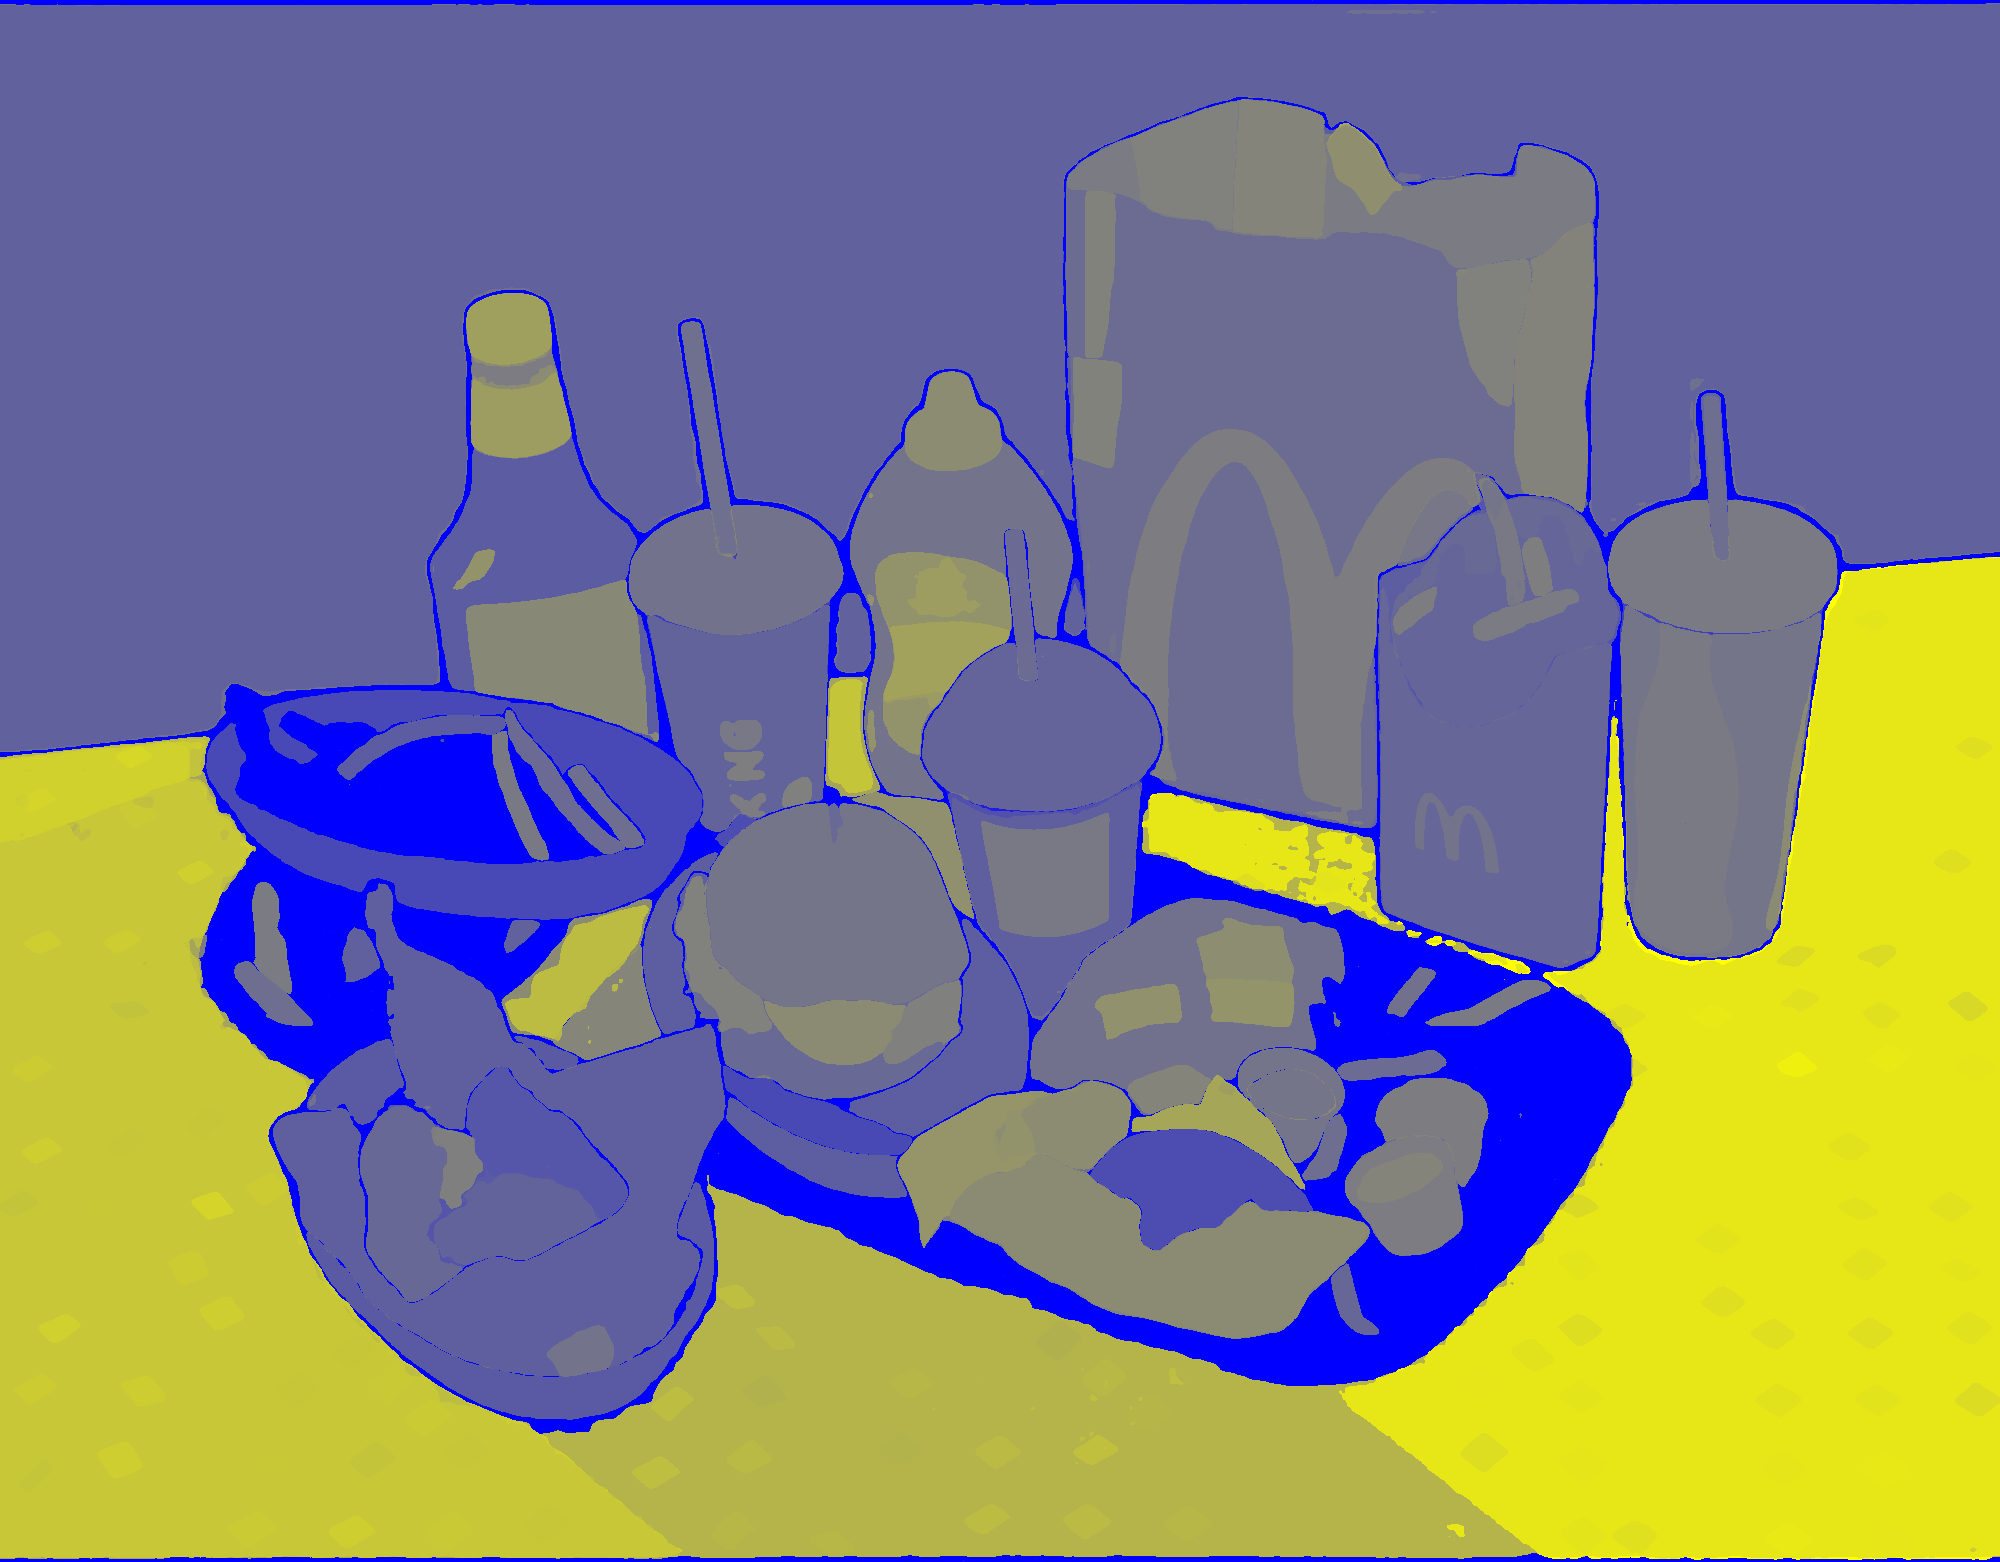

In [21]:
display(img)

In [22]:
img.save(save_dir + 'sent2_enhanced.png')